## 0.1 Intro to Neural Networks

As covered in the lecture notes, Neural Networks (NN) are inspired by biological brains. Each "neuron" does a very simple calculation, however collectively they can do powerful computations.

A simple model neuron is called a Perceptron and is comprised of three components:
1. The weights
2. The input function
3. The activation function

perceptron.png

We can re-imagine the logistic regression unit as a neuron (function) that multiplies the input by the parameters (weights) and squashes the resulting sum through the sigmoid.

A Feed Forward NN will be a connected set of logistic regression units, arranged in layers. Each unit’s output is a non-linear function (e.g., sigmoid, step function) of a linear combination of its inputs.
nn.svg

We will use the sigmoid as an activation function. Add the sigmoid function and `LogisticRegression` class from week 4 lab below.
Change the parameter initialization in `LogisticRegression`, so that a random set of initial weights is used.



<u><font color="red">**Q1.** Why is it important to use a random set of initial weights rather than initializing all weights as zero in a Neural Network? [2 marks] </font></u>


In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

torch.manual_seed(0)

In [2]:
def sigmoid(z: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-z))

In [3]:
class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1, num_features), requires_grad=False)

  def forward(self, x):
    return sigmoid(torch.matmul(x, self.weight.T))

# 1. The XOR problem

Let's revisit the XOR problem.

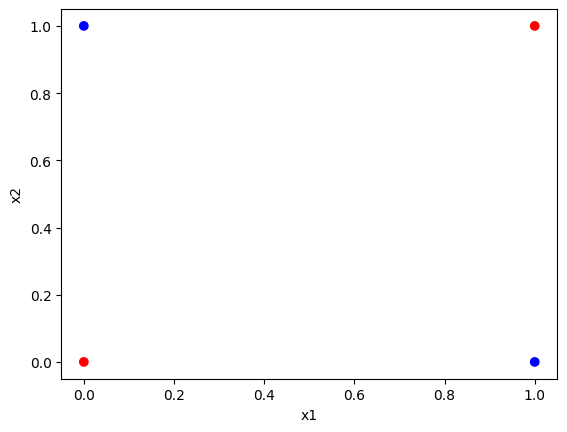

In [4]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

<u><font color="red"> **Q2.** How does a NN solve the XOR problem? [1 marks]</font></u>


We will implement back-propagation on a Feed Forward network to solve the XOR problem. The nework will have 2 inputs, 2 hidden neurons and one output neuron. The architecture is visualised as follows:

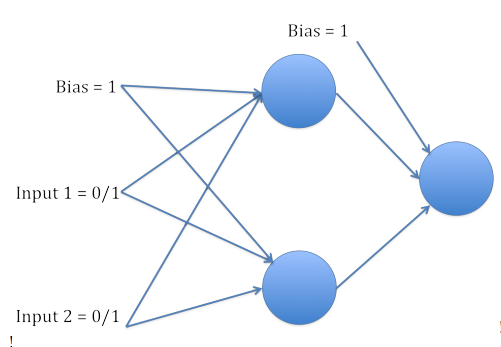

Using `LogisticRegression` and `sigmoid` from week 4 lab, implement the forward pass in the class below. Assume a single sample at a time (i.e. the shape of `x` is `(1, num_features`)). [2 marks]

Hint: Check `ModuleList` [documentation](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html).

In [7]:
class NeuralNetwork(nn.Module):
  def __init__(self, num_inputs, num_neurons, num_outputs):
    super().__init__()
    self.hidden_layer = nn.ModuleList([LogisticRegression(num_inputs) for i in range(num_neurons)])
    self.output_layer = nn.ModuleList([LogisticRegression(num_neurons+1) for i in range(num_outputs)]) # +1 for the bias

  def forward(self, x: torch.tensor) -> torch.tensor:
    y_hidden = torch.ones(len(self.hidden_layer) + 1) # +1 for the bias
    for i, layer in enumerate(self.hidden_layer):
        y_hidden[i] = layer(x).item()
    y_hidden[-1] = 1.0  # Set bias

    # Pass hidden layer output through output layer
    output = torch.cat([layer(y_hidden) for layer in self.output_layer], dim=0)
    return output

  def backward_pass(self, x: torch.tensor, y: torch.tensor, lr: float) -> None:
      y_hidden = torch.zeros(len(self.hidden_layer) + 1)  # +1 for bias
      for i, layer in enumerate(self.hidden_layer):
          y_hidden[i] = layer(x).item()
      y_hidden[-1] = 1.0

      # Forward pass
      forward_output = self.forward(x)
      y_pred = torch.sigmoid(forward_output)

      # Calculate output derivatives
      output_deltas = []
      for k, y_k in enumerate(y_pred):
          delta_k = (y_k - y[k].item()) * y_k * (1 - y_k)
          output_deltas.append(delta_k)

      # Calculate hidden layer derivatives
      hidden_deltas = []
      for j, hidden_neuron in enumerate(self.hidden_layer):
          hidden_delta = sum(output_deltas[k] * output_neuron.weight[0, j]
                              for k, output_neuron in enumerate(self.output_layer))
          hidden_deltas.append(hidden_delta * y_hidden[j] * (1 - y_hidden[j]))

      # Update output layer weights
      for k, output_neuron in enumerate(self.output_layer):
          for j in range(len(self.hidden_layer) + 1):  # +1 for bias
              alpha_j = y_hidden[j] if j < len(self.hidden_layer) else 1.0
              output_neuron.weight[0, j] -= lr * output_deltas[k] * alpha_j

      # Update hidden layer weights
      for j, hidden_neuron in enumerate(self.hidden_layer):
          for i in range(len(x)):
              hidden_neuron.weight[0, i] -= lr * hidden_deltas[j] * x[i]

In [8]:
# test it works!!
x_test = torch.tensor([0., 0., 1.]) # last value is the bias
y_test = torch.tensor([0.])
model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1)
print(model(x_test))
print(model)
for name, param in model.named_parameters():
  print(name, param)

print('\nHidden layer weight matrix:')
print(torch.stack(list(model.hidden_layer.parameters())))

tensor([0.3747])
NeuralNetwork(
  (hidden_layer): ModuleList(
    (0-1): 2 x LogisticRegression()
  )
  (output_layer): ModuleList(
    (0): LogisticRegression()
  )
)
hidden_layer.0.weight Parameter containing:
tensor([[ 1.5410, -0.2934, -2.1788]])
hidden_layer.1.weight Parameter containing:
tensor([[ 0.5684, -1.0845, -1.3986]])
output_layer.0.weight Parameter containing:
tensor([[ 0.4033,  0.8380, -0.7193]])

Hidden layer weight matrix:
tensor([[[ 1.5410, -0.2934, -2.1788]],

        [[ 0.5684, -1.0845, -1.3986]]])


In the `NeuralNetwork` class above, fill in the `backward_pass()` method.

The implementation should support outputs of any size. To implement the backward pass, follow the steps below:



*   **Step 1:** For each output, $k$, calculate the partial derivative: $\delta_{k} = (y_{k}-t_{k}) \times g'(x_{k})$ \\
where $y_{k}$ is the response of the output neuron and $t_{k}$ is the desired output (target). The derivative of the sigmoid function $g'(x_{k})$ is defined as $g'(x_{k}) = g(x_{k}) × (1 - g(x_{k}))$ [1 marks]
*  **Step 2:** We now need to propagate this error to the hidden neurons. To accomplish this remember that: $$
 \delta_{j} = g^\prime(x_{j}) \sum_{k} w_{jk} \delta_{k}
$$  where $\delta_{j}$ is the error on the j-th hidden neuron,$x_{j}$ is the value of the hidden neuron (before it has been passed through the sigmoid function), $g^\prime$ is the derivative of the sigmoid function, $\delta_{k}$ is the error from the output neuron calculated in step 1, and $w_{jk}$ is the weight from the hidden neuron $j$ to the output neuron $k$. [1 marks]

* **Step 3:** We now need to update the output weights, i.e. the connections from the hidden neurons to the output neurons. This is accomplished using the formula: $$
 w_{jk} = w_{jk} - \eta \delta_{k} \alpha_{j}
$$ where $w_{jk}$ is the weight connecting the j-th hidden neuron to the k-th output neuron. $\alpha_{j}$ is the activity of the j-th hidden neuron (after it has been transformed by the sigmoid function), $\delta_{k}$ is the error from the output neuron stored in output\_deltas and $\eta$ is the learning rate [1 mark]

* **Step 4:**  Finally we need to update the hidden weights, i.e. the connections from the hidden neurons to the inputs. Here, again we use this equation $$
 w_{ij} = w_{ij} - \eta \delta_{j} x_{i}
$$ where $w_{ij}$ is the weight connecting the i-th input to the j-th hidden neuron. $x_{i}$ is the i-th input, $\delta_{j}$ is the backpropagated error (i.e., hidden deltas) from the j-th hidden neuron and $\eta$ is the learning rate. [1 mark]



In [9]:
# test it works
model.backward_pass(x_test, y_test, 1)

Now modify the code below to train a model on the XOR problem. Make sure to use an appropriate lr and number of iterations. Use the BCE method from week 4 to visualize cost. [1 mark]

In [10]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
  return torch.mean(-y_true * torch.log(y_pred) - (1 - y_true) * torch.log(1 - y_pred))

training in progress..
Estimated time 60 seconds


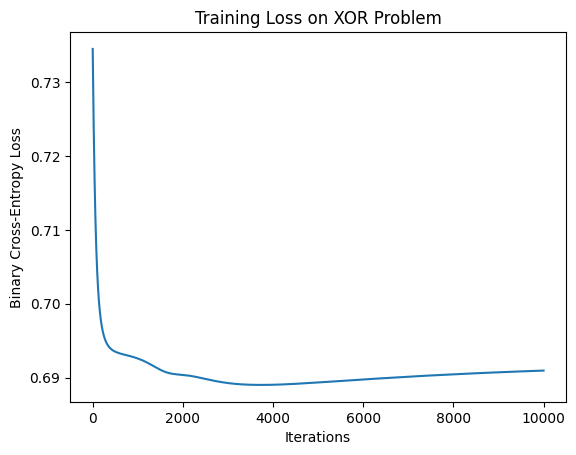

Target: tensor([0., 1., 1., 0.])
Predicted: tensor([0., 0., 1., 0.])


In [11]:
x1 = torch.tensor([0., 0., 1., 1.])
x2 = torch.tensor([0., 1., 0., 1.])
bias = torch.ones_like(x1)
x = torch.stack([x1, x2, bias]).permute(1, 0)
y = torch.tensor([0., 1., 1., 0.])

lr = 0.1
iterations = 10000

model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1)
errors = []

print('training in progress..')
print('Estimated time 60 seconds')

for ep in range(iterations):
    error = 0
    for i in range(x.shape[0]):
        # Forward pass
        y_pred = model(x[i])[0]
        y_pred = torch.sigmoid(y_pred)

        loss = bce(y[i], y_pred)
        error += loss.item()

        # Backward pass
        model.backward_pass(x[i], y[i].unsqueeze(0), lr)

    errors.append(error / x.shape[0])

plt.plot(range(iterations), errors)
plt.xlabel("Iterations")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Training Loss on XOR Problem")
plt.show()

# Prediction after training
y_pred = torch.zeros_like(y)
for i in range(x.shape[0]):
    output = model(x[i])[0]
    y_pred[i] = torch.round(torch.sigmoid(output))

print("Target:", y)
print("Predicted:", y_pred)

# 2. Iris Dataset
We will now use pytorch built-in methods to create an MLP classifier for the iris dataset.

In [12]:
iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

Split the data to train and test sets (make sure the same random seed is used as previously) and normalize using the method from week 4. We will use all attributes in this lab. [2 marks]

In [13]:
from sklearn.model_selection import train_test_split

iris_db = datasets.load_iris(as_frame=True)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris_db.data,
    iris_db.target,
    test_size=0.2,
    random_state=42
    )

x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()
y_train = torch.from_numpy(y_train.values).long()
y_test = torch.from_numpy(y_test.values).long()

In [14]:
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
  return (x - mu) / sigma

mu = torch.mean(x_train, dim=0)
sigma = torch.std(x_train, dim=0)

x_train = norm_set(x_train, mu, sigma)
x_test = norm_set(x_test, mu, sigma)

Using pytorch built in methods (and using the training loop from week 4 as guideline for the train loop), build an MLP with one hidden layer. Train the network multiple times for the following number of hidden neurons `{1, 2, 4, 8, 16, 32}`.

<u><font color="red"> **Q3.** Explain the performance of the different networks on the training and test sets. How does it compare to the logistic regression example? Make sure that the data you are refering to is clearly presented and appropriately labeled in the report. [8 marks]</font></u>

In [21]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = self.output(x)
        return x

In [29]:
def train(model, x, y, alpha):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=alpha)
  cost_lst = []

  for it in range(1000):
      optimizer.zero_grad()  # Zero gradients
      prediction = model(x)  # Forward pass
      cost = criterion(prediction, y)
      cost_lst.append(cost.item())

      cost.backward()  # Backward pass
      optimizer.step()  # Update weights

  print('Minimum cost: {}'.format(min(cost_lst)))
  return cost_lst

In [32]:
hidden_neurons_list = [1, 2, 4, 8, 16, 32]
alpha = 0.1
all_costs = {}

for hidden_neurons in hidden_neurons_list:
    print(f"\nTraining MLP with {hidden_neurons} hidden neurons")
    model = MLP(input_size=4, hidden_size=hidden_neurons, output_size=3)
    cost_lst = train(model, x_train, y_train, alpha)
    all_costs[hidden_neurons] = cost_lst


Training MLP with 1 hidden neurons
Minimum cost: 0.15095654129981995

Training MLP with 2 hidden neurons
Minimum cost: 0.0713684931397438

Training MLP with 4 hidden neurons
Minimum cost: 0.06319967657327652

Training MLP with 8 hidden neurons
Minimum cost: 0.05622288957238197

Training MLP with 16 hidden neurons
Minimum cost: 0.054783448576927185

Training MLP with 32 hidden neurons
Minimum cost: 0.05354288965463638


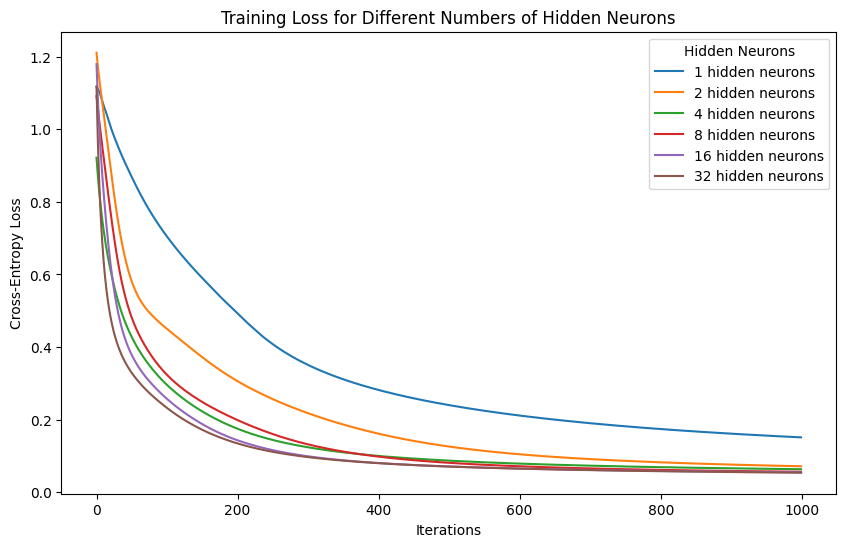

In [33]:
plt.figure(figsize=(10, 6))
for hidden_neurons, cost_lst in all_costs.items():
    plt.plot(cost_lst, label=f'{hidden_neurons} hidden neurons')

plt.xlabel("Iterations")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss for Different Numbers of Hidden Neurons")
plt.legend(title="Hidden Neurons")
plt.show()

In [34]:
def evaluate(model, x, y):
  with torch.no_grad():
      predictions = model(x)
      _, predicted_classes = torch.max(predictions, 1)
      accuracy = (predicted_classes == y).float().mean()
  return accuracy.item()

for hidden_neurons in hidden_neurons_list:
  print(f"\nTraining MLP with {hidden_neurons} hidden neurons")
  model = MLP(input_size=4, hidden_size=hidden_neurons, output_size=3)
  train(model, x_train, y_train, alpha)
  test_accuracy = evaluate(model, x_test, y_test)
  print(f"Test Accuracy with {hidden_neurons} hidden neurons: {test_accuracy:.2f}")


Training MLP with 1 hidden neurons
Minimum cost: 0.14919842779636383
Test Accuracy with 1 hidden neurons: 0.97

Training MLP with 2 hidden neurons
Minimum cost: 0.06499867141246796
Test Accuracy with 2 hidden neurons: 0.97

Training MLP with 4 hidden neurons
Minimum cost: 0.057467229664325714
Test Accuracy with 4 hidden neurons: 1.00

Training MLP with 8 hidden neurons
Minimum cost: 0.06332027167081833
Test Accuracy with 8 hidden neurons: 1.00

Training MLP with 16 hidden neurons
Minimum cost: 0.05293082445859909
Test Accuracy with 16 hidden neurons: 1.00

Training MLP with 32 hidden neurons
Minimum cost: 0.05266544595360756
Test Accuracy with 32 hidden neurons: 1.00
